In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, LinearLR

from time_transformer.transformer import Transformer
from time_transformer.utils_valid_loss_point import compute_val_point_score

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def new_mape(y_true, y_pred, max_val):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max_val)) * 100

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Data Processing\processed_data"
dataset = "L5"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['L5.csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[0])).head(2))

,ept,kw,tmp
0,2017-01-01 00:00:00,15984.0,48.0
1,2017-01-01 01:00:00,15984.0,46.8


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['ept'], usecols=['ept', 'kw', 'tmp'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,ept,kw,tmp
0,2017-01-01 00:00:00,15984.0,48.0
1,2017-01-01 01:00:00,15984.0,46.8


In [5]:
# Fetching the date column only
date_col = data.ept.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,6
1,1,1,1,6


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43824


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["kw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_A_LOAD")
display(load_ds.tail(2))

,L5_A_LOAD
43822,13122.0
43823,12042.0


In [10]:
lag_24_ahead = True

# Creating 1-day lag loads
if lag_24_ahead:
    lag_val = 1
else:
    lag_val = 2

load_lag_1 = load_ds.shift(24*lag_val).add_suffix("_LAG1")
display(load_lag_1.tail(2))

,L5_A_LOAD_LAG1
43822,16902.0
43823,15336.0


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,L5_A_LOAD_LAG7
43822,14742.0
43823,14202.0


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis=0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


ADDING LAST LOAD VALUE FROM PREVIOUS DAY AS FEATURE

In [13]:
n = 24
last_elem = pd.DataFrame(np.column_stack([np.concatenate([np.repeat(load_ds[col].values[n-1::n], n), 
                                                          np.repeat(np.NaN, len(load_ds)%n)]) for col in load_ds.columns]))
last_elem.columns = [i.removesuffix('.csv') for i in fileList]
last_elem = last_elem.add_suffix("_LAST_ELEM")
last_elem = last_elem.shift(24)
last_elem

,L5_LAST_ELEM
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
43819,15336.0
43820,15336.0
43821,15336.0
43822,15336.0


FINDING MIN AND MAX VALUES OF LOAD ON PREVIOUS DAY

In [14]:
# Creating block of indices repeating after every 24 rows
blocks = [load_lag_1[i:i+24] for i in range(0, len(load_lag_1), 24)]

# Finding max and min values on the previous day (T-1)
max_values_df = pd.DataFrame([block.max() for block in blocks])
max_values_df = max_values_df.iloc[np.repeat(np.arange(len(max_values_df)), 24)]
max_values_df = max_values_df.reset_index(drop=True)

max_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in max_values_df.columns]
max_values_df = max_values_df.add_suffix("_PREV_MAX")
print("Columns with max load from previous day: ")
display(max_values_df.tail(2))
print("\n")

min_values_df = pd.DataFrame([block.min() for block in blocks])
min_values_df = min_values_df.iloc[np.repeat(np.arange(len(min_values_df)), 24)]
min_values_df = min_values_df.reset_index(drop=True)

min_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in min_values_df.columns]
min_values_df = min_values_df.add_suffix("_PREV_MIN")
print("Columns with min load from previous day: ")
display(min_values_df.tail(2))
print("\n")

Columns with max load from previous day: 


,L5_PREV_MAX
43822,20412.0
43823,20412.0




Columns with min load from previous day: 


,L5_PREV_MIN
43822,15336.0
43823,15336.0


In [15]:
pd.DataFrame(load_lag_1.iloc[-24:].max()).T

,L5_A_LOAD_LAG1
0,20412.0


PROCESSING TEMPERATURE DATA

In [16]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmp"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
display(temp_ds.tail(2))

,L5_A_TEMP
43822,63.5
43823,63.0


### PREPARING X AND Y PART

In [17]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds, last_elem, max_values_df, min_values_df], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("NUMBER OF COLUMNS: ", len(X_continuous.columns), "\n")
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))

print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))
print("\n")

# First few values of the continuous values dataframe
print("First few values of continuous values dataframe: ")
display(X_continuous.head(2))

NUMBER OF COLUMNS:  7 

The train-test split index is:  17351
The last date of train dataset: 


,AA_ept,L5_A_LOAD_LAG1,L5_A_LOAD_LAG7,L5_A_TEMP,L5_LAST_ELEM,L5_PREV_MAX,L5_PREV_MIN
17350,2018-12-31 22:00:00,15822.0,18738.0,66.6,15336.0,17280.0,14904.0
17351,2018-12-31 23:00:00,15336.0,18846.0,66.7,15336.0,17280.0,14904.0


The first date of test dataset: 


,AA_ept,L5_A_LOAD_LAG1,L5_A_LOAD_LAG7,L5_A_TEMP,L5_LAST_ELEM,L5_PREV_MAX,L5_PREV_MIN
17352,2019-01-01 00:00:00,15714.0,19116.0,67.1,14526.0,20088.0,14526.0
17353,2019-01-01 01:00:00,16308.0,19224.0,66.9,14526.0,20088.0,14526.0




LENGTH OF DATASET:  43656


,L5_A_LOAD_LAG1,L5_A_LOAD_LAG7,L5_A_TEMP,L5_LAST_ELEM,L5_PREV_MAX,L5_PREV_MIN
43654,16902.0,14742.0,63.5,15336.0,20412.0,15336.0
43655,15336.0,14202.0,63.0,15336.0,20412.0,15336.0




First few values of continuous values dataframe: 


,L5_A_LOAD_LAG1,L5_A_LOAD_LAG7,L5_A_TEMP,L5_LAST_ELEM,L5_PREV_MAX,L5_PREV_MIN
0,22356.0,15984.0,19.2,26784.0,29430.0,22356.0
1,22950.0,15984.0,18.1,26784.0,29430.0,22356.0


In [18]:
X_continuous.isna().any()

L5_A_LOAD_LAG1    False
L5_A_LOAD_LAG7    False
L5_A_TEMP         False
L5_LAST_ELEM      False
L5_PREV_MAX       False
L5_PREV_MIN       False
dtype: bool

In [19]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
print("NUMBER OF COLUMNS: ", len(X_categorical.columns))
display(X_categorical.tail(2))

LENGTH OF DATASET:  43656
NUMBER OF COLUMNS:  74


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(2))

LENGTH OF DATASET:  43656


,L5_A_LOAD
43654,13122.0
43655,12042.0


In [21]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  17352
Test samples:  26304


In [22]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,L5_A_LOAD_LAG1,L5_A_LOAD_LAG7,L5_A_TEMP,L5_LAST_ELEM,L5_PREV_MAX,L5_PREV_MIN
17350,15822.0,18738.0,66.6,15336.0,17280.0,14904.0
17351,15336.0,18846.0,66.7,15336.0,17280.0,14904.0


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
17350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,L5_A_LOAD
17350,15552.0
17351,14526.0


In [23]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(17352, 6) (26304, 6) 

Shape for categorical variable: 
(17352, 74) (26304, 74) 

Shape for target variable: 
(17352, 1) (26304, 1) 

Does it cover entire training set:  True


### SCALING THE DATA

In [24]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [25]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
print("Shape: ", X_scaled_continuous_train.shape)
display(X_scaled_continuous_train)

Scaled continuous X train: 
Shape:  (17352, 6)


array([[0.5712098 , 0.39050536, 0.18918919, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58805513, 0.39050536, 0.17775468, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58192956, 0.38591118, 0.17047817, 0.7489083 , 0.66136364,
        0.78858351],
       ...,
       [0.40122511, 0.46554364, 0.68191268, 0.2860262 , 0.15      ,
        0.49682875],
       [0.38591118, 0.46860643, 0.68191268, 0.2860262 , 0.15      ,
        0.49682875],
       [0.37212864, 0.47166922, 0.68295218, 0.2860262 , 0.15      ,
        0.49682875]])

In [26]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
print("Shape: ", Y_scaled_train.shape)
display(Y_scaled_train)

Scaled continuous Y train: 
Shape:  (17352, 1)


array([[0.69372129],
       [0.6906585 ],
       [0.69218989],
       ...,
       [0.39816233],
       [0.37825421],
       [0.34915773]])

In [27]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [28]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[1].shape)
print("Shape of the created samples for testing: ", processed_data_test[1].shape)

Shape of the created samples for training:  (17329, 24, 6)
Shape of the created samples for testing:  (1096, 24, 6)


In [29]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.5712098 , 0.39050536, 0.18918919, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58805513, 0.39050536, 0.17775468, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58192956, 0.38591118, 0.17047817, 0.7489083 , 0.66136364,
        0.78858351],
       [0.57733538, 0.37212864, 0.16528067, 0.7489083 , 0.66136364,
        0.78858351],
       [0.57886677, 0.36906585, 0.15904366, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58652374, 0.37212864, 0.14968815, 0.7489083 , 0.66136364,
        0.78858351],
       [0.60336907, 0.38284839, 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.63093415, 0.39203675, 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.65237366, 0.4042879 , 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.68300153, 0.41500766, 0.16839917, 0.7489083 , 0.66136364,
        0.78858351],
       [0.72588055, 0.4042879 , 0.17775468, 0.7489083 , 0.66136364,
        0.78858351],
       [0.73966309, 0

In [30]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.58805513, 0.39050536, 0.17775468, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58192956, 0.38591118, 0.17047817, 0.7489083 , 0.66136364,
        0.78858351],
       [0.57733538, 0.37212864, 0.16528067, 0.7489083 , 0.66136364,
        0.78858351],
       [0.57886677, 0.36906585, 0.15904366, 0.7489083 , 0.66136364,
        0.78858351],
       [0.58652374, 0.37212864, 0.14968815, 0.7489083 , 0.66136364,
        0.78858351],
       [0.60336907, 0.38284839, 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.63093415, 0.39203675, 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.65237366, 0.4042879 , 0.14864865, 0.7489083 , 0.66136364,
        0.78858351],
       [0.68300153, 0.41500766, 0.16839917, 0.7489083 , 0.66136364,
        0.78858351],
       [0.72588055, 0.4042879 , 0.17775468, 0.7489083 , 0.66136364,
        0.78858351],
       [0.73966309, 0.39816233, 0.1954262 , 0.7489083 , 0.66136364,
        0.78858351],
       [0.75344564, 0

In [31]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [32]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([17329, 24, 74])
Shape of continuous samples - training:  torch.Size([17329, 24, 6])
Shape of target samples - training:  torch.Size([17329, 24, 1])


Shape of categorical samples - testing:  torch.Size([1096, 24, 74])
Shape of continuous samples - testing:  torch.Size([1096, 24, 6])
Shape of target samples - testing:  torch.Size([1096, 24, 1])


### CREATING DATALOADER

In [33]:
BATCH_SIZE = 512

In [34]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [35]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [37]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  34
Number of batches in test dataloader:  3


In [38]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([17329, 24, 74])
Shape of continuous variables:  torch.Size([17329, 24, 6])
Shape of target variables:  torch.Size([17329, 24, 1])


In [39]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  1
Number of features per zone:  6


### DEFINING LOSS FUNCTION

In [40]:
loss_function = nn.MSELoss()

### DEFINING MODEL ARCHITECTURE

In [41]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 1e-4,
            "weight_decay": 1e-3,
            "max_iter": 1000,
            "epochs": 200,
            "update_freq": 10
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": num_zone_features + 3 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 1,                                                       # Model output -> Point predictions
            "d_model": 100,                                                      # Model latent dimension
            "q": 3,                                                              # Query and Key dimensions
            "v": 3,                                                              # Value dimensions
            "h": 3,                                                              # Number of heads
            "N": 1,                                                              # Number of stacked of encoder and decoder
            "attention_size": 24*7,                                              # Attention window
            "dropout": 0.5,                                                      # Dropout rate
            "pe": "regular",                                                     # Positional encoding used
            "chunk_mode": None,                                                  # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [42]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L5_best_zone_1.pth"))

vae_models = nn.ModuleList([vae_model_1])
print("Number of vae models: ", len(vae_models))

Number of vae models:  1


In [43]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  1


In [44]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        zonal_continuous_reconstr = zonal_continuous[:, :, :3]
        out_var = self.zonal_vae(zonal_continuous_reconstr)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [45]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [46]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### SPECIFYING EARLY STOPPING FUNCTION

In [47]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, 
                 path="best_model.pth", trace_func=print,
                 model_name="model_x"):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
        self.model_name = model_name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'[{self.model_name}] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'[{self.model_name}] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [48]:
early_stop_patience = 5

model_path_1 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_1.pth")

early_stopping_1 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_1, model_name="model_1")

### DEFINING ZONAL MODEL

In [49]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)

In [50]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

### PERFORMING MODEL TRAINING


[Epoch     1 of 200] loss_1: 0.022296 val_loss_1: 0.015081
[model_1] Validation loss decreased (inf --> 0.015081).  Saving model ...

[Epoch     2 of 200] loss_1: 0.014839 val_loss_1: 0.011276
[model_1] Validation loss decreased (0.015081 --> 0.011276).  Saving model ...

[Epoch     3 of 200] loss_1: 0.011907 val_loss_1: 0.009615
[model_1] Validation loss decreased (0.011276 --> 0.009615).  Saving model ...

[Epoch     4 of 200] loss_1: 0.010544 val_loss_1: 0.008751
[model_1] Validation loss decreased (0.009615 --> 0.008751).  Saving model ...

[Epoch     5 of 200] loss_1: 0.009674 val_loss_1: 0.008028
[model_1] Validation loss decreased (0.008751 --> 0.008028).  Saving model ...

[Epoch     6 of 200] loss_1: 0.008754 val_loss_1: 0.007664
[model_1] Validation loss decreased (0.008028 --> 0.007664).  Saving model ...

[Epoch     7 of 200] loss_1: 0.008159 val_loss_1: 0.007298
[model_1] Validation loss decreased (0.007664 --> 0.007298).  Saving model ...

[Epoch     8 of 200] loss_1: 0.

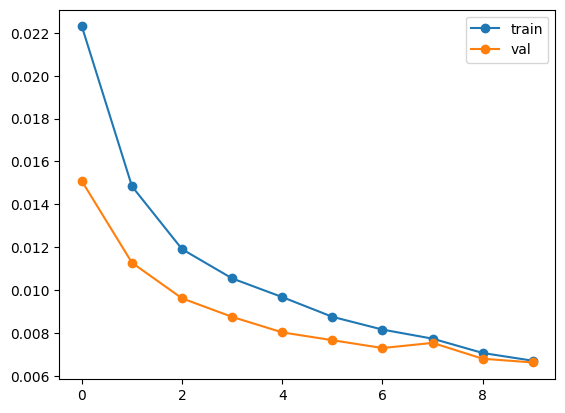


[Epoch    11 of 200] loss_1: 0.006386 val_loss_1: 0.006452
[model_1] Validation loss decreased (0.006625 --> 0.006452).  Saving model ...

[Epoch    12 of 200] loss_1: 0.005804 val_loss_1: 0.006192
[model_1] Validation loss decreased (0.006452 --> 0.006192).  Saving model ...

[Epoch    13 of 200] loss_1: 0.005588 val_loss_1: 0.006330
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    14 of 200] loss_1: 0.005363 val_loss_1: 0.006004
[model_1] Validation loss decreased (0.006192 --> 0.006004).  Saving model ...

[Epoch    15 of 200] loss_1: 0.005067 val_loss_1: 0.005881
[model_1] Validation loss decreased (0.006004 --> 0.005881).  Saving model ...

[Epoch    16 of 200] loss_1: 0.004918 val_loss_1: 0.005760
[model_1] Validation loss decreased (0.005881 --> 0.005760).  Saving model ...

[Epoch    17 of 200] loss_1: 0.004608 val_loss_1: 0.005675
[model_1] Validation loss decreased (0.005760 --> 0.005675).  Saving model ...

[Epoch    18 of 200] loss_1: 0.004608 val_loss_1: 0.005721
[m

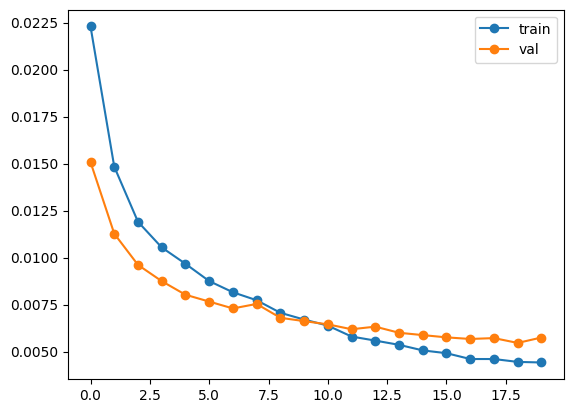


[Epoch    21 of 200] loss_1: 0.004348 val_loss_1: 0.005312
[model_1] Validation loss decreased (0.005464 --> 0.005312).  Saving model ...

[Epoch    22 of 200] loss_1: 0.004079 val_loss_1: 0.005520
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    23 of 200] loss_1: 0.003874 val_loss_1: 0.005179
[model_1] Validation loss decreased (0.005312 --> 0.005179).  Saving model ...

[Epoch    24 of 200] loss_1: 0.003878 val_loss_1: 0.005361
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    25 of 200] loss_1: 0.003741 val_loss_1: 0.005303
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    26 of 200] loss_1: 0.003805 val_loss_1: 0.005084
[model_1] Validation loss decreased (0.005179 --> 0.005084).  Saving model ...

[Epoch    27 of 200] loss_1: 0.003678 val_loss_1: 0.005715
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    28 of 200] loss_1: 0.003943 val_loss_1: 0.005091
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    29 of 200] loss_1: 0.003458 val_loss_1: 0.004969
[mo

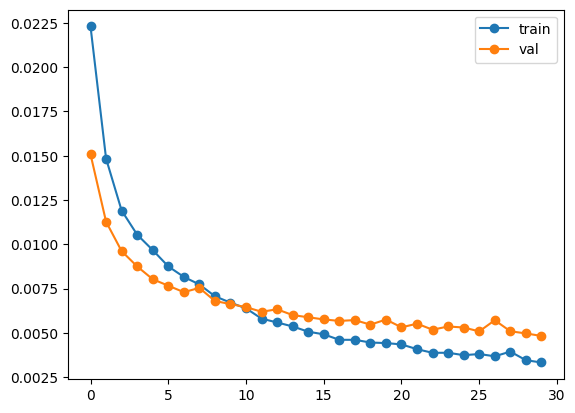


[Epoch    31 of 200] loss_1: 0.003538 val_loss_1: 0.005116
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    32 of 200] loss_1: 0.003362 val_loss_1: 0.004739
[model_1] Validation loss decreased (0.004826 --> 0.004739).  Saving model ...

[Epoch    33 of 200] loss_1: 0.003279 val_loss_1: 0.004798
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    34 of 200] loss_1: 0.003289 val_loss_1: 0.004721
[model_1] Validation loss decreased (0.004739 --> 0.004721).  Saving model ...

[Epoch    35 of 200] loss_1: 0.003262 val_loss_1: 0.004650
[model_1] Validation loss decreased (0.004721 --> 0.004650).  Saving model ...

[Epoch    36 of 200] loss_1: 0.003111 val_loss_1: 0.004585
[model_1] Validation loss decreased (0.004650 --> 0.004585).  Saving model ...

[Epoch    37 of 200] loss_1: 0.003351 val_loss_1: 0.004489
[model_1] Validation loss decreased (0.004585 --> 0.004489).  Saving model ...

[Epoch    38 of 200] loss_1: 0.003045 val_loss_1: 0.004424
[model_1] Validation loss decreased (

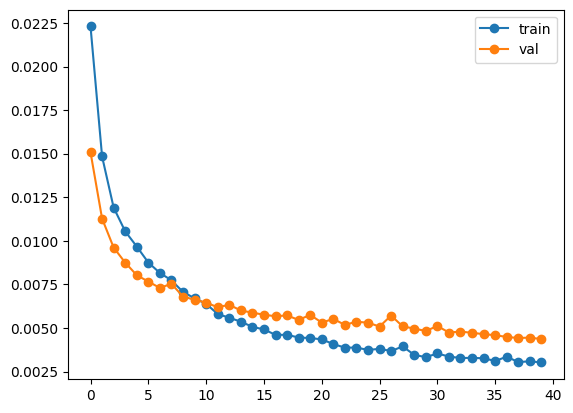


[Epoch    41 of 200] loss_1: 0.003001 val_loss_1: 0.004300
[model_1] Validation loss decreased (0.004361 --> 0.004300).  Saving model ...

[Epoch    42 of 200] loss_1: 0.002919 val_loss_1: 0.004272
[model_1] Validation loss decreased (0.004300 --> 0.004272).  Saving model ...

[Epoch    43 of 200] loss_1: 0.002901 val_loss_1: 0.004472
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    44 of 200] loss_1: 0.002844 val_loss_1: 0.004167
[model_1] Validation loss decreased (0.004272 --> 0.004167).  Saving model ...

[Epoch    45 of 200] loss_1: 0.002877 val_loss_1: 0.004137
[model_1] Validation loss decreased (0.004167 --> 0.004137).  Saving model ...

[Epoch    46 of 200] loss_1: 0.002769 val_loss_1: 0.004114
[model_1] Validation loss decreased (0.004137 --> 0.004114).  Saving model ...

[Epoch    47 of 200] loss_1: 0.002677 val_loss_1: 0.004064
[model_1] Validation loss decreased (0.004114 --> 0.004064).  Saving model ...

[Epoch    48 of 200] loss_1: 0.002692 val_loss_1: 0.004050
[m

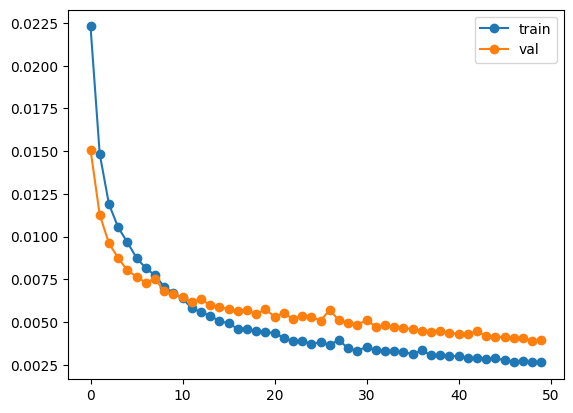


[Epoch    51 of 200] loss_1: 0.002503 val_loss_1: 0.004011
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    52 of 200] loss_1: 0.002658 val_loss_1: 0.003950
[model_1] EarlyStopping counter: 3 out of 5

[Epoch    53 of 200] loss_1: 0.002532 val_loss_1: 0.003787
[model_1] Validation loss decreased (0.003890 --> 0.003787).  Saving model ...

[Epoch    54 of 200] loss_1: 0.002474 val_loss_1: 0.003877
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    55 of 200] loss_1: 0.002454 val_loss_1: 0.003648
[model_1] Validation loss decreased (0.003787 --> 0.003648).  Saving model ...

[Epoch    56 of 200] loss_1: 0.002318 val_loss_1: 0.003541
[model_1] Validation loss decreased (0.003648 --> 0.003541).  Saving model ...

[Epoch    57 of 200] loss_1: 0.002327 val_loss_1: 0.003598
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    58 of 200] loss_1: 0.002314 val_loss_1: 0.003403
[model_1] Validation loss decreased (0.003541 --> 0.003403).  Saving model ...

[Epoch    59 of 200] loss_1

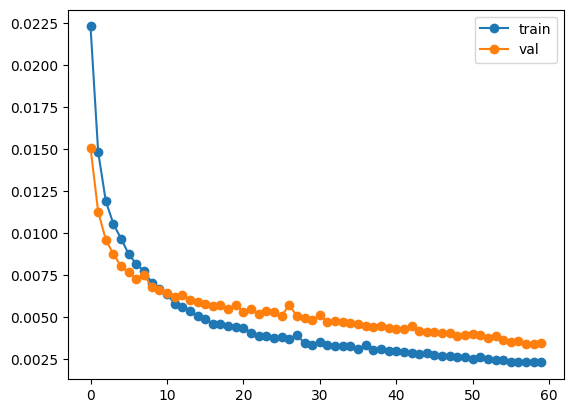


[Epoch    61 of 200] loss_1: 0.002232 val_loss_1: 0.003391
[model_1] Validation loss decreased (0.003396 --> 0.003391).  Saving model ...

[Epoch    62 of 200] loss_1: 0.002159 val_loss_1: 0.003318
[model_1] Validation loss decreased (0.003391 --> 0.003318).  Saving model ...

[Epoch    63 of 200] loss_1: 0.002130 val_loss_1: 0.003283
[model_1] Validation loss decreased (0.003318 --> 0.003283).  Saving model ...

[Epoch    64 of 200] loss_1: 0.002217 val_loss_1: 0.003433
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    65 of 200] loss_1: 0.002116 val_loss_1: 0.003188
[model_1] Validation loss decreased (0.003283 --> 0.003188).  Saving model ...

[Epoch    66 of 200] loss_1: 0.002101 val_loss_1: 0.003183
[model_1] Validation loss decreased (0.003188 --> 0.003183).  Saving model ...

[Epoch    67 of 200] loss_1: 0.002093 val_loss_1: 0.003141
[model_1] Validation loss decreased (0.003183 --> 0.003141).  Saving model ...

[Epoch    68 of 200] loss_1: 0.002040 val_loss_1: 0.003129
[m

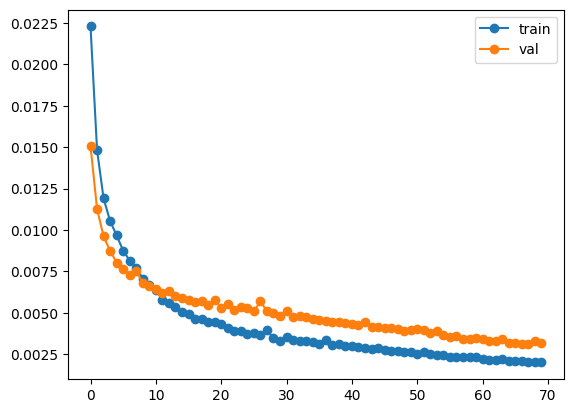


[Epoch    71 of 200] loss_1: 0.001983 val_loss_1: 0.003132
[model_1] EarlyStopping counter: 3 out of 5

[Epoch    72 of 200] loss_1: 0.001978 val_loss_1: 0.003121
[model_1] Validation loss decreased (0.003129 --> 0.003121).  Saving model ...

[Epoch    73 of 200] loss_1: 0.001963 val_loss_1: 0.003122
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    74 of 200] loss_1: 0.002042 val_loss_1: 0.003174
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    75 of 200] loss_1: 0.001932 val_loss_1: 0.002977
[model_1] Validation loss decreased (0.003121 --> 0.002977).  Saving model ...

[Epoch    76 of 200] loss_1: 0.001941 val_loss_1: 0.003025
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    77 of 200] loss_1: 0.001946 val_loss_1: 0.003156
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    78 of 200] loss_1: 0.001946 val_loss_1: 0.002984
[model_1] EarlyStopping counter: 3 out of 5

[Epoch    79 of 200] loss_1: 0.001899 val_loss_1: 0.002969
[model_1] Validation loss decreased (0

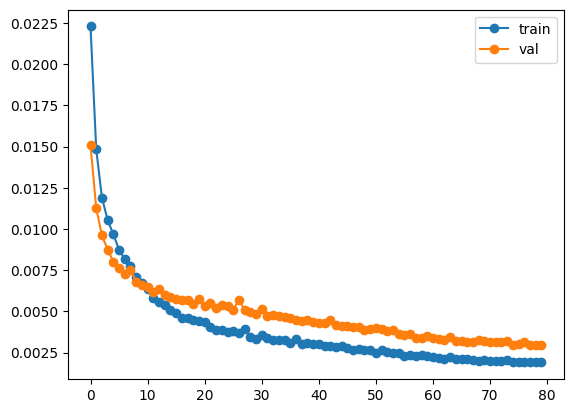


[Epoch    81 of 200] loss_1: 0.001931 val_loss_1: 0.002962
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    82 of 200] loss_1: 0.001931 val_loss_1: 0.002965
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    83 of 200] loss_1: 0.001896 val_loss_1: 0.003036
[model_1] EarlyStopping counter: 3 out of 5

[Epoch    84 of 200] loss_1: 0.001906 val_loss_1: 0.002936
[model_1] Validation loss decreased (0.002957 --> 0.002936).  Saving model ...

[Epoch    85 of 200] loss_1: 0.001887 val_loss_1: 0.002974
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    86 of 200] loss_1: 0.001884 val_loss_1: 0.002967
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    87 of 200] loss_1: 0.001891 val_loss_1: 0.002928
[model_1] Validation loss decreased (0.002936 --> 0.002928).  Saving model ...

[Epoch    88 of 200] loss_1: 0.001887 val_loss_1: 0.002946
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    89 of 200] loss_1: 0.001894 val_loss_1: 0.002966
[model_1] EarlyStopping counter: 2 out

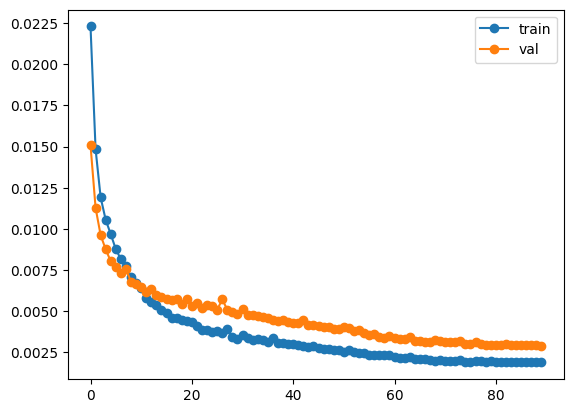


[Epoch    91 of 200] loss_1: 0.001890 val_loss_1: 0.003037
[model_1] EarlyStopping counter: 1 out of 5

[Epoch    92 of 200] loss_1: 0.001888 val_loss_1: 0.002920
[model_1] EarlyStopping counter: 2 out of 5

[Epoch    93 of 200] loss_1: 0.001889 val_loss_1: 0.002923
[model_1] EarlyStopping counter: 3 out of 5

[Epoch    94 of 200] loss_1: 0.001905 val_loss_1: 0.002895
[model_1] EarlyStopping counter: 4 out of 5

[Epoch    95 of 200] loss_1: 0.001891 val_loss_1: 0.002935
[model_1] EarlyStopping counter: 5 out of 5
Early stopping - model_1
Early stopping


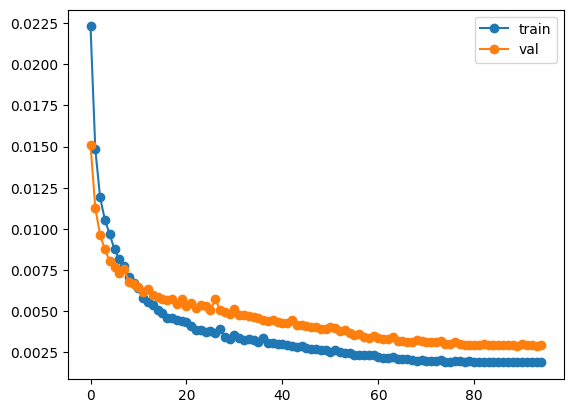


Total time of training: 0.36311565001805624 hours


In [51]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
val_hist_loss_1 = np.zeros(config_args.epochs)

val_loss_best_1 = np.inf
count_1 = 0

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()

    running_loss_1 = 0

    for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

        # Setting the gradients to zero
        optimizer_1.zero_grad()

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)

        # Calculating the pinball loss
        loss_1 = loss_function(out_transformer_1, zone_1_target.to(device))

        # Back-Propagating the loss
        loss_1.backward()

        # Updating the parameters
        optimizer_1.step()

        # Accumulating the running loss
        running_loss_1 += loss_1.item()

        train_loss_1 = running_loss_1/len(train_dataloader)

        val_loss_1 = compute_val_point_score(model_1, test_dataloader,
                                             loss_function, "zone_1",
                                             device).item()

        hist_loss_1[epoch] = train_loss_1

        val_hist_loss_1[epoch] = val_loss_1

    
    print('\n[Epoch {t:5d} of {epochs}] loss_1: {loss_1:1.6f} val_loss_1: {val_loss_1:1.6f}'.format(t=epoch+1, 
                                                                                                    epochs=config_args.epochs, 
                                                                                                    loss_1=train_loss_1, 
                                                                                                    val_loss_1=val_loss_1,))
    
    # Employing early stopping to avoid overfitting
    early_stopping_1(val_loss_1, model_1)

    if early_stopping_1.early_stop and count_1 < 1:
        print("Early stopping - {}".format(early_stopping_1.model_name))

    if early_stopping_1.early_stop:
      print("Early stopping")
      break

    if (epoch + 1) % config_args.update_freq == 0:
        print("The plots at epoch {} are:\n".format(epoch+1))
        plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        
plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
plt.legend()
plt.show()
        
end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [52]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, model_path_1)

In [53]:
point_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0

# Switching all models to eval mode
model_1.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)

        # Concatenating the predictions
        point_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]

100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [54]:
# Reshaping the predicted quantiles
point_pred_arr_1 = point_pred_1.reshape(-1, model_args.d_output)

point_pred_arr_1.shape

(26304, 1)

In [55]:
point_pred_1_inv = point_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]

point_pred_1_inv.shape

(26304, 1)

In [56]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()

yArr_1.shape

(26304, 1)

In [57]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]

#### CALCULATING THE MAPE ON TEST DATA

In [58]:
compare_df_1 = pd.DataFrame(data= {"Values": yArr_1_inv[:, 0], "Predictions": point_pred_1_inv[:, 0]})
compare_df_1

,Values,Predictions
0,13824.000000,14958.434272
1,13824.000000,16306.270455
2,13878.000000,16136.090461
3,13770.000000,15711.995600
4,14040.000000,15924.459183
...,...,...
26299,14796.000000,18757.153877
26300,14148.000000,18270.677164
26301,13716.000000,17758.752112
26302,13122.000000,17062.540976


In [59]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L5_vae_transformer_1.pth")

print("Saved !")

Saving the best trained models.
Saved !


#### EXAMINING THE RESULTS

In [60]:
mape_max_val = mm_scaler_Y.data_max_.max()

New MAPE:  3.827676314737652
Old MAPE:  3.838738963046142


<Axes: >

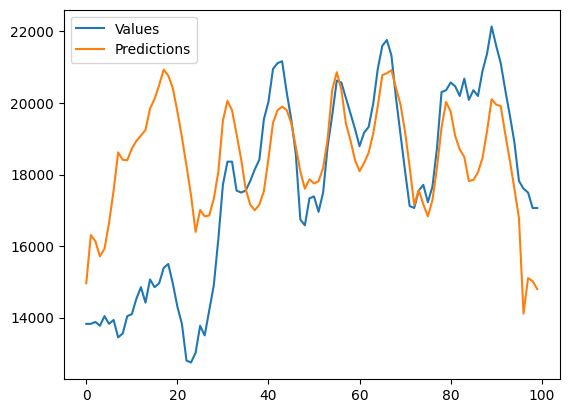

In [61]:
result_mape_1 = new_mape(compare_df_1["Values"], compare_df_1["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_1)
print("Old MAPE: ", mape(compare_df_1["Values"], compare_df_1["Predictions"]))
compare_df_1.iloc[:100].plot()

In [62]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["mape"] = [
result_mape_1, 
]

resultsDf.to_csv(os.path.join("lag_24_results", "new_v3_" + dataset + ".csv"), index=False)
print("Results saved !")

resultsDf

Results saved !


,zone,mape
0,L5,3.827676


In [63]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [64]:
oldResultsDf = pd.DataFrame()
oldResultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
oldResultsDf["mape"] = [
    mape(compare_df_1["Values"], compare_df_1["Predictions"]), 
]

oldResultsDf.to_csv(os.path.join("lag_24_results", "old_v3_" + dataset + ".csv"), index=False)
print("Results saved !")

oldResultsDf

Results saved !


,zone,mape
0,L5,3.838739
